In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

Read data, generate difference

In [2]:
pxlst_raw=['a.mid', 'b.mid', 'c.mid']
hbaslst_raw=['a.hbas', 'b.hbas', 'c.hbas']

In [3]:
df_all = pd.read_csv('data/traindata.csv', index_col=[0])

In [4]:
pxlst=pxlst_raw.copy()
for i in range(len(pxlst_raw)):
    for j in range(i+1,len(pxlst_raw)):
        col_i = pxlst_raw[i]
        col_j = pxlst_raw[j]
        col_new = col_i+'_'+col_j
        pxlst.append(col_new)
        df_all[col_new] = df_all[col_i] - df_all[col_j]
#
hbaslst=hbaslst_raw.copy()
for i in range(len(hbaslst_raw)):
    for j in range(i+1,len(hbaslst_raw)):
        col_i = hbaslst_raw[i]
        col_j = hbaslst_raw[j]
        col_new = col_i+'_'+col_j
        hbaslst.append(col_new)
        df_all[col_new] = df_all[col_i] + df_all[col_j]

mean reversion

In [5]:
# data with column 'spread', 'hbas'
def get_info(data, window = 30, entry_threshold = 2.0, exit_threshold = 1.0, stop_loss_threshold = 2.5):


    data['mean'] = data['spread'].rolling(window).mean()
    data['std'] = data['spread'].rolling(window).std()
    data['z_score'] = (data['spread'] - data['mean']) / data['std']
    
    
    # Initialize variables for tracking positions and PnL
    data['position'] = 0  # 1 for long, -1 for short, 0 for no position
    entry_price = 0
    entry_type = 0  # 1 for long, -1 for short
    pnl = []
    cumulative_pnl = 0
    
    # Generate signals with stop loss and calculate PnL
    for i in range(1, len(data)):
        if data['position'].iloc[i-1] == 0:  # No existing position
            if data['z_score'].iloc[i] < -entry_threshold:
                data.loc[data.index[i], 'position'] = 1  # Enter long
                entry_price = data['spread'].iloc[i]
                entry_type = 1
                trade_pnl = - data['hbas'].iloc[i]
                pnl.append(trade_pnl)
                cumulative_pnl += trade_pnl
            elif data['z_score'].iloc[i] > entry_threshold:
                data.loc[data.index[i], 'position'] = -1  # Enter short
                entry_price = data['spread'].iloc[i]
                entry_type = -1
                trade_pnl = - data['hbas'].iloc[i]
                pnl.append(trade_pnl)
                cumulative_pnl += trade_pnl
        else:  # Existing position
            if entry_type == 1:  # Long position
                if  entry_price - data['spread'].iloc[i] > stop_loss_threshold * data['std'].iloc[i]:
                    data.loc[data.index[i], 'position'] = 0  # Stop loss exit
                    trade_pnl = data['spread'].iloc[i] - entry_price - data['hbas'].iloc[i]
                    pnl.append(trade_pnl)
                    cumulative_pnl += trade_pnl
                elif data['z_score'].iloc[i] > -exit_threshold:
                    data.loc[data.index[i], 'position'] = 0  # Normal exit
                    trade_pnl = data['spread'].iloc[i] - entry_price - data['hbas'].iloc[i]
                    pnl.append(trade_pnl)
                    cumulative_pnl += trade_pnl
                else:
                    data.loc[data.index[i], 'position'] = 1  # Hold position
            elif entry_type == -1:  # Short position
                if data['spread'].iloc[i] - entry_price > stop_loss_threshold * data['std'].iloc[i]:
                    data.loc[data.index[i], 'position'] = 0  # Stop loss exit
                    trade_pnl = entry_price - data['spread'].iloc[i] - data['hbas'].iloc[i]
                    pnl.append(trade_pnl)
                    cumulative_pnl += trade_pnl
                elif data['z_score'].iloc[i] < exit_threshold:
                    data.loc[data.index[i], 'position'] = 0  # Normal exit
                    trade_pnl = entry_price - data['spread'].iloc[i] - data['hbas'].iloc[i]
                    pnl.append(trade_pnl)
                    cumulative_pnl += trade_pnl
                else:
                    data.loc[data.index[i], 'position'] = -1  # Hold position
    
    # Convert pnl list to a pandas Series for cumulative PnL
    pnl_series = pd.Series(pnl)
    cumulative_pnl_series = pnl_series.cumsum()
    return cumulative_pnl, cumulative_pnl_series

a.mid_b.mid 139428.57264546727


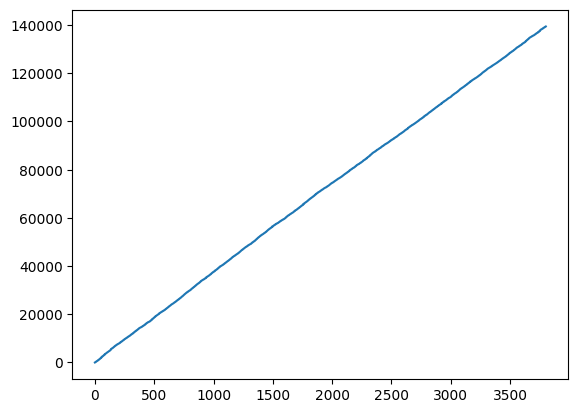

a.mid_c.mid 138341.26743046605


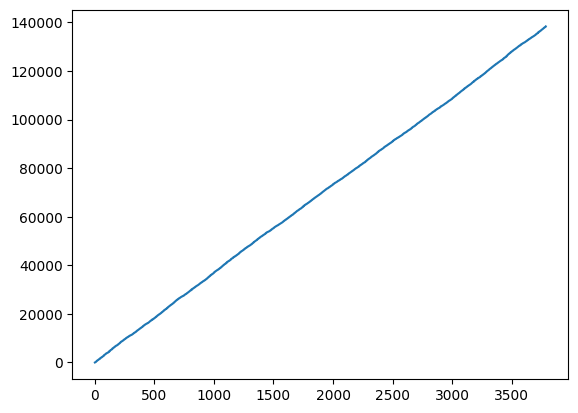

b.mid_c.mid 135415.41162535347


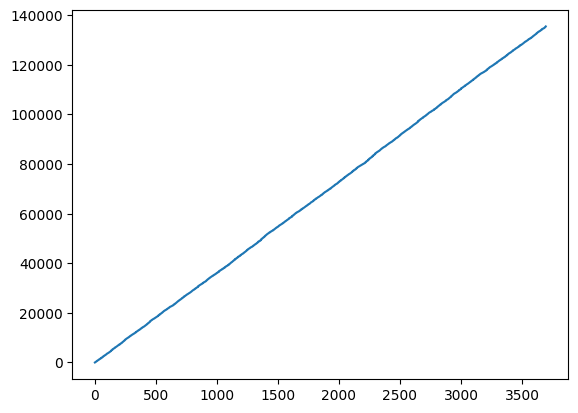

In [6]:
for i in range(3,len(pxlst)):
    mid_name = pxlst[i]
    hbas_name = hbaslst[i]
    df_now = df_all[ [mid_name, hbas_name] ].copy()
    new_column_names = {}
    new_column_names[mid_name]='spread'
    new_column_names[hbas_name]='hbas'
    df_now.rename(columns=new_column_names, inplace=True)
    cumulative_pnl, cumulative_pnl_series = get_info(df_now, window = 30, entry_threshold = 2.0, exit_threshold = 1.0, stop_loss_threshold = 2.5)
    print(mid_name, cumulative_pnl)
    plt.plot(cumulative_pnl_series)
    plt.show()

In [8]:
window_lst = list( np.round( 2**np.arange(4,7) ) )
entry_threshold_lst = list( 1.0+0.5*np.arange(3) )
exit_threshold_lst = list( 0.5+0.5*np.arange(3) )
stop_loss_threshold_lst = list( 2.0+0.5*np.arange(1) )
for i in range(3,len(pxlst)):
    for window in window_lst:
        for entry_threshold in entry_threshold_lst:
            for exit_threshold in exit_threshold_lst:
                for stop_loss_threshold in stop_loss_threshold_lst:
                    if exit_threshold>entry_threshold:
                        continue
                    mid_name = pxlst[i]
                    hbas_name = hbaslst[i]
                    df_now = df_all[ [mid_name, hbas_name] ].copy()
                    new_column_names = {}
                    new_column_names[mid_name]='spread'
                    new_column_names[hbas_name]='hbas'
                    df_now.rename(columns=new_column_names, inplace=True)
                    cumulative_pnl, cumulative_pnl_series = get_info(df_now, window = window, entry_threshold = entry_threshold,
                                                                     exit_threshold = exit_threshold, stop_loss_threshold = stop_loss_threshold)
                    print(mid_name, window,entry_threshold,exit_threshold,stop_loss_threshold,  cumulative_pnl)
                    #plt.plot(cumulative_pnl_series)
                    #plt.show()

a.mid_b.mid 16 1.0 0.5 2.0 594307.5525298372
a.mid_b.mid 16 1.0 1.0 2.0 557064.0884763245
a.mid_b.mid 16 1.5 0.5 2.0 346326.9902883089
a.mid_b.mid 16 1.5 1.0 2.0 322223.02287816507
a.mid_b.mid 16 1.5 1.5 2.0 302632.2343880279
a.mid_b.mid 16 2.0 0.5 2.0 122160.46520582362
a.mid_b.mid 16 2.0 1.0 2.0 113647.63829597339
a.mid_b.mid 16 2.0 1.5 2.0 107073.93552058293
a.mid_b.mid 32 1.0 0.5 2.0 607768.6745093294
a.mid_b.mid 32 1.0 1.0 2.0 573911.797057725
a.mid_b.mid 32 1.5 0.5 2.0 364647.4148941398
a.mid_b.mid 32 1.5 1.0 2.0 341650.2762267668
a.mid_b.mid 32 1.5 1.5 2.0 322395.24928970827
a.mid_b.mid 32 2.0 0.5 2.0 148898.78899270602
a.mid_b.mid 32 2.0 1.0 2.0 139682.65273473633
a.mid_b.mid 32 2.0 1.5 2.0 131676.99758948505
a.mid_b.mid 64 1.0 0.5 2.0 616009.837142517
a.mid_b.mid 64 1.0 1.0 2.0 582989.2232337693
a.mid_b.mid 64 1.5 0.5 2.0 377588.5668953902
a.mid_b.mid 64 1.5 1.0 2.0 353536.88004565204
a.mid_b.mid 64 1.5 1.5 2.0 333914.9615416297
a.mid_b.mid 64 2.0 0.5 2.0 162135.19011829686
a.

KeyboardInterrupt: 

In [ ]:
2**np.arange(2,5)